# Traffic Sign Recognition

### 2024, Spring - Szabo Lorand

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import math

## 1. Denoising using Median Filtering

This algorithm takes the image, a window size and for each pixel it calculates the median of each pixel in its neighbourhood, and setting the result to new pixel's value.

In [2]:
def median_filter(image, window_size):
    pad_size = window_size // 2 # floor division

    # adds border/padding of size pad_size to the image
    padded_image = cv2.copyMakeBorder(image, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_REFLECT)

    filtered_image = np.zeros_like(image)

    for i in range(pad_size, padded_image.shape[0] - pad_size):
        for j in range(pad_size, padded_image.shape[1] - pad_size):
            neighbourhood = padded_image[i - pad_size : i + pad_size + 1, j - pad_size : j + pad_size + 1, :]

            # iterate through R, G, B values
            for k in range(3):
                filtered_image[i - pad_size, j - pad_size, k] = np.median(neighbourhood[:, :, k])
                # the offset of the padding is subtracted

    return filtered_image

## Contrast Enhancement Algorithm

The simple contrast enhancement algorithm computes the histogram of the grayscale input image (originally colored) and calculates the normalized cumulative distribution function (CDF) that shows how many pixels have lower or equal value to a certain value. Then, it interpolates the original values to obtain the full color scale, based on the normalized CDF. In other words, where the slope of the CDF is shallower, more pixel intensities are mapped to the same value. This results in an image that uses the a larger color scale than the original one.

The purpose of doing operations (histogram calculation) on the grayscale image is to not distort the proportion of the 3 color scales, which by applying the algorithm should remain constant.

__Result:__

The algorithm can be tested using the plot_histogram function and on the CDF function shallow slopes can be observed at the beginning (black) and at the end (white) of the scale. This results in peaks at the beginning and at the end of the histograms.

This algorithm is not used in the final implementation because it scales each color's value, therefore it creates quite dark colors. It would work on grayscale images, however not on RGB images.

In [3]:
def colored_to_grayscale(image):
    height = image.shape[0]
    width = image.shape[1]
    colors = image.shape[2]

    grayscale_image = np.zeros((height, width), dtype = np.uint8)

    for i in range(height):
        for j in range(width):
            b, g, r = image[i, j]
            # using the magic formula to calculate grayscale - already normalized
            grayscale_intensity = int(0.299 * r + 0.587 * g + 0.114 * b)
            grayscale_image[i, j] = grayscale_intensity

    return grayscale_image

In [4]:
def contrast_enhancement(image, plot):
    gray_image = colored_to_grayscale(image)
    hist, bins = np.histogram(gray_image.flatten(), 256, [0, 256])

    cdf = hist.cumsum()

    # formula from the lab pdf with goutmin = 0 and goutmax = 255: gout = ginmin + (gin - ginmin) * (goutmax - goutmin) / (ginmax ginmin)
    cdf_normalized = ((cdf - cdf.min()) * 255) / (cdf.max() - cdf.min())

    enhanced_image = np.zeros_like(image)
    for i in range(3):
        interpolated_values = np.interp(image[:,:,i].flatten(), bins[:-1], cdf_normalized)
        enhanced_image[:,:,i] = interpolated_values.reshape(image[:,:,i].shape).astype(np.uint8)

    if plot:
        plot_histogram(image, enhanced_image, cdf_normalized)
    return enhanced_image

Display histogram and CDF:

In [5]:
def plot_histogram(image, enhanced_image, cdf_normalized):
    # Plot the histogram for each color channel
    plt.figure(figsize=(15, 5))
    for i, color in enumerate(['red', 'green', 'blue']):
        plt.subplot(1, 3, i+1)
        plt.hist(image[:,:,i].flatten(), 256, [0, 256], color=color, alpha=0.5, label='Original')
        plt.hist(enhanced_image[:,:,i].flatten(), 256, [0, 256], color='m', alpha=0.5, label='Enhanced')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.title(f'Histogram for Channel {color.upper()}')
        plt.legend()
        
    plt.tight_layout()
    plt.show()
    
    # plot CDF
    plt.subplot(1, 2, 2)
    plt.plot(cdf_normalized, color='g')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('CDF')
    plt.title('Cumulative Distribution Function (CDF)')
    
    plt.show()

## Testing Image Preprocessing

Read input, set up parameters:

In [6]:
noisy_image = cv2.imread('./Images/1.jpg', cv2.IMREAD_COLOR)
window_size = 3

Denoise image:

In [7]:
# denoised_image = median_filter(noisy_image, window_size)

# cv2.imshow('Noisy image', noisy_image)
# cv2.imshow('Denoised image', denoised_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Contrast enhancement:

In [8]:
# enhanced_image = contrast_enhancement(noisy_image, 1)

# cv2.imshow('Contrasty image', enhanced_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### Canny Edge Detection

Firstly, the denoised and contrast-enhanced image has to be transformed to grayscale and than the edge detection algorithm can be applied to it.

Canny Edge detection is not used in the pipeline, because I found alternative ways to detect shapes in case of traffic signs.

__Preprocessing:__

In [9]:
denoised_image = median_filter(noisy_image, window_size)
# enhanced_denoised_image = contrast_enhancement(denoised_image, 0)
gray_image_processed = colored_to_grayscale(denoised_image)

__Edge Detection:__

In [10]:
# edges = cv2.Canny(gray_image_processed, 100, 200)

# cv2.imshow("Edges", edges)
# cv2.waitKey(0)

## 2. Color-based Segmentation

For each color a threshold interval is defined in HSV color scheme and the pixels that are in that range are added to the color's corresponding image. Traffic signs can be of 3 colors: red, yellow and blue, sometimes black, therefore 4 binary images will be created for the 4 colors - 255 (white) representing pixel of the respective color, 0 (black) every other pixel.

To implement this idea color masks will be used with the colors' intervals and applied to the original image.

After that, an __openning__ and a __closing__ morphological operation will be applied in order to filter out noise: the openning removes the white noise in the black area, while the closing removes black noise in the white area.

In [11]:
# define color thresholds

# Red
lower_red1 = (0, 100, 100)
upper_red1 = (10, 255, 255)
lower_red2 = (165, 100, 100)
upper_red2 = (179, 255, 255)

# Blue
lower_blue = (90, 100, 100)
upper_blue = (120, 255, 255)

# Yellow
lower_yellow = (20, 100, 100)
upper_yellow = (35, 255, 255)

# Black
lower_black = (0, 0, 0)
upper_black = (179, 255, 5)

def color_segmentation(image, window_size = None):
    # transform image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # create a mask for each color range
    mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    mask_blue = cv2.inRange(hsv_image, lower_blue, upper_blue)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    mask_black = cv2.inRange(hsv_image, lower_black, upper_black)

    mask_red = mask_red1 | mask_red2

    if window_size is not None:
        window = np.ones(window_size, np.uint8)
    else:
        window = np.ones((3, 3), np.uint8)

    mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_OPEN, window)
    mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_CLOSE, window)
    
    mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_OPEN, window)
    mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_CLOSE, window)

    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_OPEN, window)
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, window)
    
    mask_black = cv2.morphologyEx(mask_black, cv2.MORPH_OPEN, window)
    mask_black = cv2.morphologyEx(mask_black, cv2.MORPH_CLOSE, window)

    # create a data frame with the masks
    dict = {
        'red': mask_red,
        'blue': mask_blue,
        'yellow': mask_yellow,
        'black': mask_black
    }


    return dict


Helper function to display an image using matplotlib instead of OpenCV because the high-resolution images displayed using cv2.imshow cannot be resized so that they are completely visible and, on the other hand, in matplotlib scroll is possible.

In [12]:
def display_image(image, title):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

Applying the color segmentation on the image:

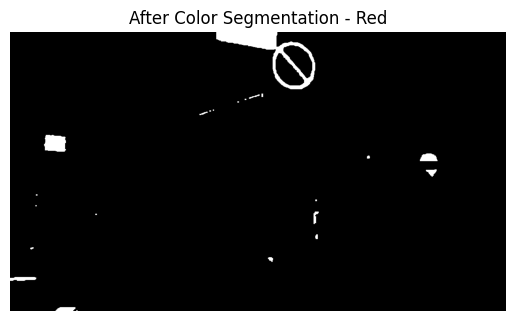

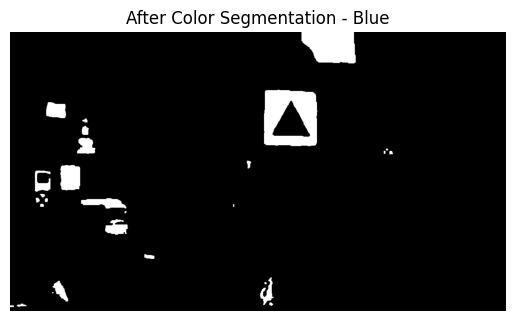

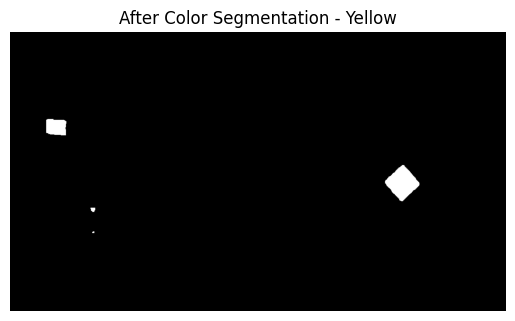

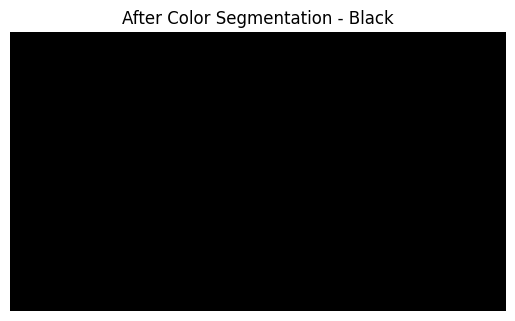

In [13]:
color_signs = color_segmentation(denoised_image)

display_image(color_signs['red'], "After Color Segmentation - Red")
display_image(color_signs['blue'], "After Color Segmentation - Blue")
display_image(color_signs['yellow'], "After Color Segmentation - Yellow")
display_image(color_signs['black'], "After Color Segmentation - Black")

## 3. Shape Detection

### Contour Drawing

Implement contour drawing by going through the whole image and painting white the pixels that are white and have a black neighbor, meaning they are contour pixels, and leaving the other pixels black.

In [14]:
def draw_contour(image):
    contour_image = np.zeros_like(image)
    offsets = [(i, j) for i in range(-1, 2) for j in range(-1, 2)]

    # leave 1 pixel for the offsets
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if image[i, j] != 0:
                for di, dj in offsets:
                    if image[i + di, j + dj] == 0:
                        contour_image[i, j] = 255
                        break

    return contour_image

Applying contour detection on the image:

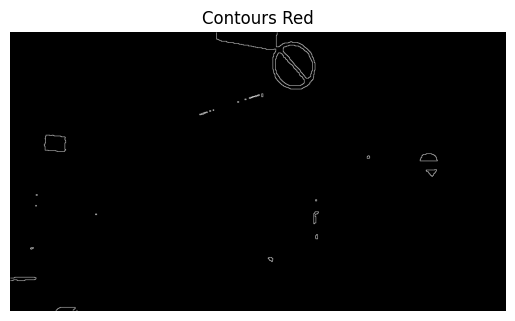

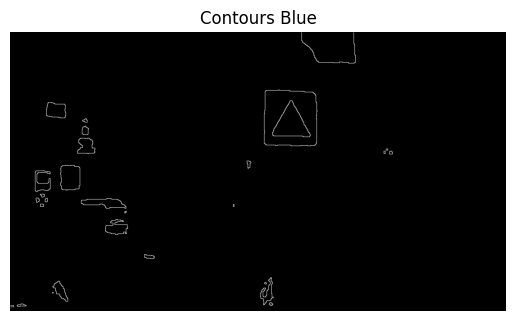

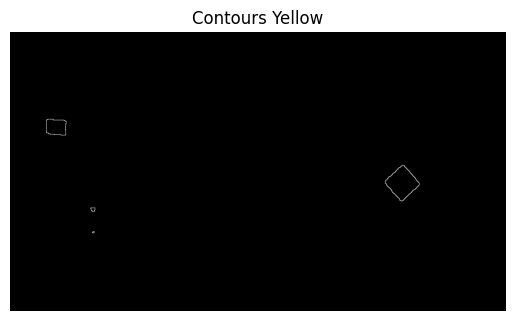

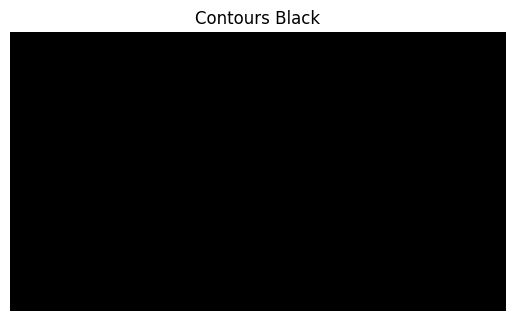

In [15]:
contour_red = draw_contour(color_signs["red"])
contour_yellow = draw_contour(color_signs["yellow"])
contour_blue = draw_contour(color_signs["blue"])
contour_black = draw_contour(color_signs["black"])

display_image(contour_red, "Contours Red")
display_image(contour_blue, "Contours Blue")
display_image(contour_yellow, "Contours Yellow")
display_image(contour_black, "Contours Black")

The following method is a helper function that converts the contour image to a tuple of contours, each contour being a list of points, that are also represented as an array of length 2.

In [16]:
def contour_image_to_array(contour_image):
    contour_array = []

    for i in range(contour_image.shape[0]):
        for j in range(contour_image.shape[1]):
            if contour_image[i, j] != 0:
                contour_array.append(np.array([[j, i]], dtype=np.int32)) # (x, y)

    return contour_array

## 4. Shape Classification

#### Circle Hough Transform algorithm

This is a feature extraction algorithm used to detect circles. In my case, it is used to detect round traffic signs.

In [17]:
hough_circle_parameters = {
    "dp": 1,
    "minDist": 150,
    "param1": 200,
    "param2": 15,
    "minRadius": 10,
    "maxRadius": 100
}

def detect_circles(img, hough_dict):
    mask = np.zeros_like(img)
    circles = cv2.HoughCircles(
        img,
        cv2.HOUGH_GRADIENT,
        hough_dict["dp"], 
        hough_dict["minDist"], 
        param1=hough_dict["param1"], 
        param2=hough_dict["param2"],
        minRadius=hough_dict["minRadius"], 
        maxRadius=hough_dict["maxRadius"],
    )
    if circles is None:
        return None, None
    else:
        largest_circle = max(circles[0], key=lambda c: c[2])
        center_x, center_y, radius = largest_circle
        x = int(center_x - radius)
        y = int(center_y - radius)
        w = int(2 * radius)
        h = int(2 * radius)
        bounding_box = (x, y, w, h)
        return largest_circle, bounding_box

Given a contour, this function gets its lowest x and y coordinates, and its width and height. In other words, calculates its bounding rectangle.

In [18]:
def boundingRect(contour):
    minX = minY = 10000
    maxX = maxY = 0

    for p in contour:
        x, y = p[0], p[1]
        minX = min(minX, x)
        minY = min(minY, y)
        maxX = max(maxX, x)
        maxY = max(maxY, y)

    w = maxX- minX
    h = maxY - minY

    return minX, minY, w, h

### Classification based on the number of nodes in the polygon

Firstly, the curve perimeter of the contour is calculated that is used to calculate a reasonable value for _epsilon_.

After that, the polygon is approximated by the _Douglas-Peucker algorithm_ that is an iterative method to reduce the number of nodes in a polygon. Basically, it compares the maximum perpendicular distance of a point from the line formed of the start and end points. If this distance is smaller than the _epsilon_ received as a parameter, then it can be removed. Otherwise, keep the point.

This algorithm results in an array of kept vertices and its length will give the number of nodes a shape has. Based on this, triangles, rectangle, stop signs (octangles, hexagons) and complex shapes can be derived. For more detailed classification of complex shapes, _hough circle detection_ is applied, in order to classify round object as circles.

Additionally, the shape of the input contour and its bounding box are returned.

In [19]:
def detect_shape(contour, image_segment):

    def center_of_gravity(contour):
        if len(contour) == 0:
            return None, None
        sumX = sumY = 0
        sumX = sum(p[0] for p in contour)
        sumY = sum(p[1] for p in contour)
        centerX = sumX / len(contour)
        centerY = sumY / len(contour)
        return centerX, centerY


    def calculate_perimeter(contour):
        perimeter = 0
        n = len(contour)
        for i in range(n):
            x1, y1 = contour[i]
            x2, y2 = contour[(i + 1) % n]
            perimeter += ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5
        return perimeter

    def perpendicular_distance(point, line_start, line_end):
        if line_start[0] == line_end[0] and line_start[1] == line_end[1]:
            return math.dist(point, line_start)
        else:
            n = abs((line_end[1] - line_start[1]) * point[0] - (line_end[0] - line_start[0]) * point[1] + line_end[0] * line_start[1] - line_end[1] * line_start[0])
            d = math.sqrt((line_end[1] - line_start[1]) ** 2 + (line_end[0] - line_start[0]) ** 2)
            return n / d

    def douglas_peucker(PointList, epsilon):
        dmax = 0
        index = 0
        end = len(PointList)
        for i in range(1, end - 1):
            d = perpendicular_distance(PointList[i], PointList[0], PointList[-1])
            if d > dmax:
                index = i
                dmax = d

        ResultList = []

        if dmax > epsilon:
            recResults1 = douglas_peucker(PointList[:index + 1], epsilon)
            recResults2 = douglas_peucker(PointList[index:], epsilon)
            ResultList = recResults1[:-1] + recResults2
        else:
            ResultList = [PointList[0], PointList[-1]]

        return ResultList
    
    perimeter = calculate_perimeter(contour)
    
    epsilon = 0.03 * perimeter
    approx_polygon = douglas_peucker(contour, epsilon)
    
    num_vertices = len(approx_polygon) - 1

    x, y, w, h = boundingRect(contour)
    bounding_box = (x, y, w, h)
    
    # Determine the shape based on the number of vertices
    if num_vertices == 3:
        shape = "Triangle"

        _, centerY = center_of_gravity(contour)

        # Calculate y-coordinate of the center of the image
        image_center_y = y + h // 2
        
        # Check if centroid is in the upper half of the image
        if centerY < image_center_y:
            orientation = "Upside down"
        else:
            orientation = "Normal"
        
        shape += f" ({orientation})"
        
    elif num_vertices == 4:
        if h != 0:
            aspect_ratio = float(w) / h
            if 0.95 <= aspect_ratio <= 1.05:
                shape = "Square"
            else:
                shape = "Rectangle"
        else:
            shape = "Unknown"
    elif num_vertices == 8 | num_vertices == 6:
        shape = "Stop"
    elif num_vertices > 4:
        circle, circle_bounding_box = detect_circles(image_segment, hough_circle_parameters)
        if circle is not None:
            shape = "Circle"
            x1, y1, w1, h1 = circle_bounding_box
            bounding_box = (x + x1, y + y1, w1, h1)
        else:
            shape = "Complex Shape"
    else:
        shape = "Unknown"
    return shape, bounding_box

### Converting the image of the contours to a list of contours, separating each connected component

__Algorithm:__
- use _depth-first search_ in the contour image received to separate each connected component and to add the pixels to the list
- the result has to be a tuple of numpy arrays of connected components, each array having a list of pixels, that are also represented as a list (array) of 2 elements
- run the DFS for each unvisited pixel that is a contour pixel to get each connected component

__Observation:__ using 4-neighborhood works better than using 8-neighborhood

In [20]:
def findContours(image):
    height, width = image.shape
    visited = np.zeros_like(image, dtype=bool)
    contours = []

    def get_neighbors(x, y):
        neighbors = []
        # for dx, dy in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]:
        for dx, dy in [(-1, 0), (0, -1), (0, 1), (1, 0)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < width and 0 <= ny < height:
                neighbors.append((nx, ny))
        return neighbors

    def dfs(x, y, contour):
        if(visited[y, x]):
            return
        visited[y, x] = True
        contour.append([x, y])
        for nx, ny in get_neighbors(x, y):
            if image[ny, nx] != 0 and not visited[ny, nx]:
                dfs(nx, ny, contour)

    for y in range(height):
        for x in range(width):
            if image[y, x] != 0 and not visited[y, x]:
                contour = []
                dfs(x, y, contour)
                if contour:
                    contours.append(contour)

    return tuple(np.array(contour, dtype=np.int32) for contour in contours)

In [21]:
def detect_shapes(image, color):
    # contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = findContours(image)
    # print(contours)
    largest_bounding_box = None
    largest_bounding_box_area = 0
    largest_shape = None

    shapes = []
    
    for contour in contours:
        x, y, w, h = boundingRect(contour)
        image_segment = image[y:y+h, x:x+w]
        shape, bounding_box = detect_shape(contour, image_segment)

        # print(f"Debug: Shape: {shape}, Bounding Box: {bounding_box}")  # Debug print
        shapes.append((shape, bounding_box))


    return shapes

Detect shapes in the image:

In [22]:
shapes_red = detect_shapes(contour_red, "red")
shapes_yellow = detect_shapes(contour_yellow, "yellow")
shapes_black = detect_shapes(contour_black, "black")
shapes_blue = detect_shapes(contour_blue, "blue")

### 5. Traffic Sign Classification

Use heuristic methods (a lot of if statements) to classify traffic signs based on the color calculated during color segmentation and the shape resulted by the shape detection algorithm.

For a more detailed classification the inner contents of the sign have to be analysed, such as text, using _optical character recognition (OCR)_, another layer of shape detection and classification or computer vision models could solve the problem more accurately.

In [23]:
def classify_traffic_signs(shapes, color):
    classifications = []
    for shape, bounding_box in shapes:
        if color == "red":
            if shape == "Triangle (Upside down)":
                classification = "Give way"
            elif shape == "Triangle (Normal)":
                classification = "Warning/Danger sign"
            elif shape == "Circle":
                classification = "Prohibitory sign"
            elif shape == "Stop":
                classification = "Stop"
            else:
                classification = "Unknown red sign"
        elif color == "yellow":
            if (shape == "Square") | (shape == "Rectangle"):
                classification = "Priority road"
            else:
                classification = "Unknown yellow sign"
        elif color == "black":
            if (shape == "Square") | (shape == "Rectangle"):
                classification = "Information sign"
            else:
                classification = "Unknown black sign"
        elif color == "blue":
            if shape == "Circle":
                classification = "Mandatory sign"
            elif (shape == "Rectangle") | (shape == "Square"):
                classification = "Information sign"
            else:
                classification = "Unknown blue sign"
        else:
            classification = "Unknown color sign"

        if classification != "Unknown yellow sign":
            classifications.append((classification, bounding_box))
        print(f"Classification: {classification}, Bounding Box: {bounding_box}")
    
    return classifications

## 6. Filtering the Shapes

Filter out shapes that are relatively small or inside another bounding box because they are noisy and redundant, respectively.

In [24]:
def filter_box_by_relative_area(classifications, percentage = 0.25):
    max_area = 0
    areas = []

    filtered_classes = []

    for classification in classifications:
        shape, bounding_box = classification
        x, y, w, h = bounding_box
        area = w * h
        if area > max_area:
            max_area = area

    for classification in classifications:
        shape, bounding_box = classification
        x, y, w, h = bounding_box
        area = w * h
        if area > max_area * percentage:
            filtered_classes.append(classification)

    return filtered_classes

In [25]:
def filter_contained_boxes(classifications):
    def is_contained(inner_box, outer_box):
        ix, iy, iw, ih = inner_box
        ox, oy, ow, oh = outer_box
        return ox <= ix and oy <= iy and ox + ow >= ix + iw and oy + oh >= iy + ih

    filtered_classes = []
    n = len(classifications)
    
    for i in range(n):
        contained = False
        _, inner_box = classifications[i]
        for j in range(n):
            if i != j:
                _, outer_box = classifications[j]
                if is_contained(inner_box, outer_box):
                    contained = True
                    break
        if not contained:
            filtered_classes.append(classifications[i])

    return filtered_classes

Apply classification for the shapes resulted from shape detection algorithm and merge the 4 color-based classes, filtering out the small and contained shapes at the end.

In [26]:
class_red = classify_traffic_signs(shapes_red, "red")
class_yellow = classify_traffic_signs(shapes_yellow, "yellow")
class_blue = classify_traffic_signs(shapes_blue, "blue")
class_black = classify_traffic_signs(shapes_black, "black")

merged_classes = class_red + class_yellow + class_blue + class_black
merged_classes = filter_box_by_relative_area(merged_classes)
merged_classes = filter_contained_boxes(merged_classes)

Classification: Prohibitory sign, Bounding Box: (605, 29, 96, 96)
Classification: Prohibitory sign, Bounding Box: (646, 30, 46, 46)
Classification: Prohibitory sign, Bounding Box: (618, 64, 51, 51)
Classification: Unknown red sign, Bounding Box: (584, 143, 3, 7)
Classification: Unknown red sign, Bounding Box: (555, 145, 24, 9)
Classification: Unknown red sign, Bounding Box: (545, 155, 3, 2)
Classification: Unknown red sign, Bounding Box: (528, 161, 3, 2)
Classification: Unknown red sign, Bounding Box: (471, 180, 2, 2)
Classification: Unknown red sign, Bounding Box: (463, 182, 3, 2)
Classification: Unknown red sign, Bounding Box: (440, 185, 18, 7)
Classification: Unknown red sign, Bounding Box: (79, 239, 50, 38)
Classification: Unknown red sign, Bounding Box: (952, 282, 40, 17)
Classification: Unknown red sign, Bounding Box: (829, 287, 6, 6)
Classification: Unknown red sign, Bounding Box: (966, 319, 24, 16)
Classification: Unknown red sign, Bounding Box: (60, 377, 3, 2)
Classification: 

In [27]:
def draw_classifications(image, classifications):
    for classification, bounding_box in classifications:
        x, y, w, h = bounding_box
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, classification, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

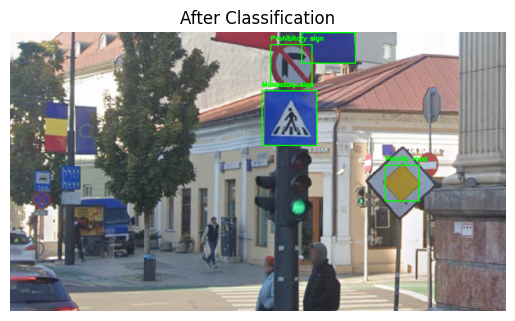

In [28]:
result_image = noisy_image.copy()
draw_classifications(result_image, merged_classes)

display_image(result_image, "After Classification")

## Resulting Pipeline

Reading in the image (slower part because of median filtering):

In [31]:
noisy_image = cv2.imread('./Images/2.jpg', cv2.IMREAD_COLOR)
window_size = 3

if noisy_image is None:
    print("Error: Image not found or unable to load.")
else:
    print("Successfully loaded image")

denoised_image = median_filter(noisy_image, window_size)

Successfully loaded image


Detection and classification part:

In [ ]:
color_signs = color_segmentation(denoised_image)

contour_red = draw_contour(color_signs["red"])
contour_yellow = draw_contour(color_signs["yellow"])
contour_blue = draw_contour(color_signs["blue"])
contour_black = draw_contour(color_signs["black"])

shapes_red = detect_shapes(contour_red, "red")
shapes_yellow = detect_shapes(contour_yellow, "yellow")
shapes_black = detect_shapes(contour_black, "black")
shapes_blue = detect_shapes(contour_blue, "blue")

class_red = classify_traffic_signs(shapes_red, "red")
class_yellow = classify_traffic_signs(shapes_yellow, "yellow")
class_blue = classify_traffic_signs(shapes_blue, "blue")
class_black = classify_traffic_signs(shapes_black, "black")

merged_classes = class_red + class_yellow + class_blue + class_black
merged_classes = filter_box_by_relative_area(merged_classes)
merged_classes = filter_contained_boxes(merged_classes)

result_image = noisy_image.copy()
draw_classifications(result_image, merged_classes)
display_image(result_image, "After Classification")